# Computing ground-truth generalized likelihood
via the integral:

$$ \mathcal{L}(\theta|x_o) = e^{-\beta \int{p(x|\theta)d(x,x_o)dx}} $$

where

- $p(x|\theta)$ is given analytically by the simulator,
- $d(x,x_o)$ is the chosen distance function in data space,
- $\beta$ is a scaling factor over distance (temperature).

or, via Monte Carlo estimate:

$$ e^{-\beta \mathbb{E}_{p(x|\theta)} \left[ d(x,x_o) \right]} $$

---

to dos:
- write likelihood_fn for the other tasks

In [1]:
import sbibm
import torch
import matplotlib.pyplot as plt

In [75]:
def mse_dist(xs, x_o):
    return torch.mean((xs - x_o)**2, dim=1)

def make_2d_grid(d1_bounds, d2_bounds, d1_res=100, d2_res=100):
    x1 = torch.linspace(*d1_bounds, d1_res)
    x2 = torch.linspace(*d2_bounds, d2_res)
    xs = torch.stack(torch.meshgrid(x1, x2))
    xs = torch.reshape(xs, (2, d1_res*d2_res)).T
    return xs


### this does things in the wrong order
# def reference_generalized_likelihood(thetas, x_o, xs, dist_func, log_prob_fn, beta=1.):
#     # pad batch dimension
#     if thetas.dim()==1:
#         thetas = thetas.unsqueeze(0)
    
#     # only have to compute this once for the x grid
#     tempered_distances = (-beta * dist_func(xs, x_o)).exp()
    
#     # loop over all thetas to get generalized likelihood
#     integral = torch.stack([(tempered_distances * log_prob_fn(theta, xs).exp()).sum() for theta in thetas])
#     return integral


def reference_generalized_loglikelihood(thetas, x_o, xs, dist_func, log_prob_fn):
    # pad batch dimension
    if thetas.dim()==1:
        thetas = thetas.unsqueeze(0)
    
    # technically have to account for the dx to normalize 
    integral = torch.stack([(dist_func(xs, x_o) * (log_prob_fn(theta, xs).exp())).sum() for theta in thetas])
    
    return integral

def reference_generalized_loglikelihood_sample(thetas, x_o, dist_func, simulator, n_per_theta=100):
    # pad batch dimension
    if thetas.dim()==1:
        thetas = thetas.unsqueeze(0)
        
    integral_mc = torch.stack([dist_func(simulator(theta.repeat((n_per_theta, 1))), x_o).mean() for theta in thetas])
    
    return integral_mc

In [68]:
print(sbibm.get_available_tasks())

task_name =  "two_moons" # "gaussian mixture" has no likelihood
obs_num = 3

task = sbibm.get_task(task_name)
log_prob_fn = task._likelihood
prior = task.get_prior()
x_o = task.get_observation(num_observation=obs_num)
beta = 1000.

xs = make_2d_grid((-1.5,1.5), (-1.5, 1.5), 200,200)
th_res = (100, 100)
thetas = make_2d_grid((-1,1), (-1,1), th_res[0], th_res[1])

# theta = torch.Tensor([1,1])
# generalized_likelihood(theta, x_o, xs, mse_dist, log_prob_fn, beta=1000.)

['two_moons', 'gaussian_mixture', 'gaussian_linear', 'bernoulli_glm', 'gaussian_linear_uniform', 'slcp', 'sir', 'lotka_volterra', 'slcp_distractors', 'bernoulli_glm_raw']


In [65]:
gl = reference_generalized_loglikelihood(thetas, x_o, xs, mse_dist, log_prob_fn)
gl = torch.reshape(gl, th_res)

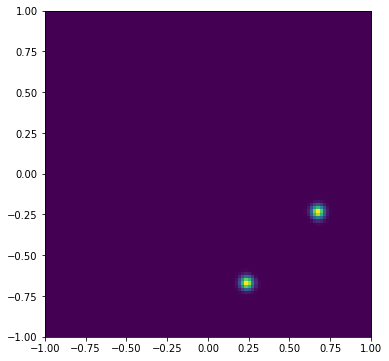

In [72]:
beta = 1
plt.figure(figsize=(6,6))
_ = plt.imshow((gl * -beta).exp().numpy().T, extent=[-1,1,-1,1], origin='lower')

In [73]:
from sbi.inference import MCMCPosterior, RejectionPosterior
from sbi.inference.potentials.base_potential import BasePotential
from sbi.utils import BoxUniform

In [92]:
class GBIPotential(BasePotential):
    allow_iid_x = False
    def __init__(self, prior, x_o, gen_llh_fn, beta=1.):
        super().__init__(prior, x_o)
        self.gen_llh_fn = gen_llh_fn
        
    def __call__(self, theta, track_gradients = True):
        # integral based
        # return -beta * self.gen_llh_fn(theta, self.x_o, xs, mse_dist, log_prob_fn) + self.prior.log_prob(theta)
        
        # sampled based
        return -beta * self.gen_llh_fn(theta, self.x_o, mse_dist, simulator, n_per_theta=500) + self.prior.log_prob(theta)


In [94]:
beta = 1000
prior = BoxUniform(low=torch.Tensor((-1, -1)), high=torch.Tensor((1, 1)))
# gbi_potential = GBIPotential(prior, x_o, reference_generalized_loglikelihood, beta=beta)
gbi_potential = GBIPotential(prior, x_o, reference_generalized_loglikelihood_sample, beta=beta)
sampler = MCMCPosterior(gbi_potential, prior)
# sampler = RejectionPosterior(gbi_potential, prior)
theta_posterior_samples = sampler.sample((10,))
theta_np = theta_posterior_samples.numpy()

  0%|          | 0/50 [00:00<?, ?it/s]

  0%|          | 0/200 [00:00<?, ?it/s]

(-1.0, 1.0)

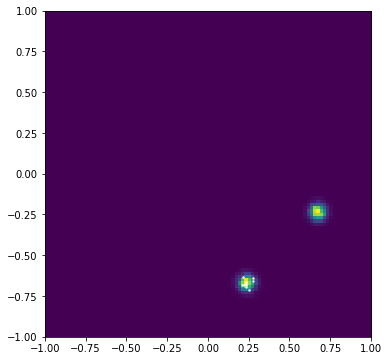

In [99]:
plt.figure(figsize=(6,6))
plt.imshow((-beta*gl).exp().numpy().T, extent=[-1,1,-1,1], origin='lower')
plt.plot(theta_np[:,0], theta_np[:,1], 'w.', ms=3, alpha=0.8)
plt.xlim([-1,1]); plt.ylim([-1,1])

---
### Sample-based 

In [97]:
simulator = task.get_simulator()
gl = reference_generalized_loglikelihood_sample(thetas, x_o, mse_dist, simulator, n_per_theta=500)
gl = torch.reshape(gl, th_res)

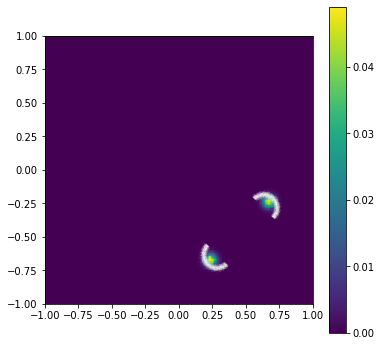

In [102]:
beta = 1000
posterior_samples = task.get_reference_posterior_samples(obs_num).numpy()
plt.figure(figsize=(6,6))
_ = plt.imshow((gl_mc * -beta).exp().numpy().T, extent=[-1,1,-1,1], origin='lower')
plt.plot(posterior_samples[:,0], posterior_samples[:,1], 'w.', ms=0.5, alpha=0.1)
plt.colorbar()

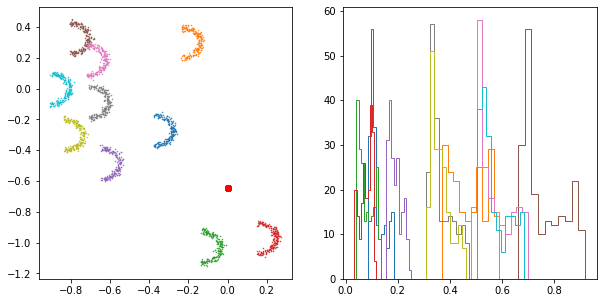

In [44]:
dist_func = mse_dist
import numpy as np
plt.figure(figsize=(10,5))
for n in np.random.choice(len(thetas), 10):
    plt.subplot(1,2,1)
    xs = simulator(thetas[n].repeat((200, 1)))
    plt.plot(xs[:,0].numpy(), xs[:,1].numpy(), '.', ms=1)
    plt.plot(x_o[:,0], x_o[:,1], 'ro')
    
    plt.subplot(1,2,2)
    d = dist_func(xs, x_o)
    plt.hist(d, histtype='step')